In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean.cm as cmo
import cartopy.crs as ccrs
import gsw
from eofs.xarray import Eof
from scipy.fft import fft, fftfreq
import pandas as pd
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


from utils import *
from utils_variability import *

# Data processing

## Loading data

In [3]:
ds_surface = load_surface_data()
print(f'Size of the dataset: {ds_surface.nbytes/1e9} GB')

Size of the dataset: 1.229445704 GB


In [4]:
ds_atm = load_atm_data()
print(f'Size of the dataset: {ds_atm.nbytes/1e9} GB')

Size of the dataset: 2.810157224 GB


In [5]:
ds = xr.merge([ds_surface, ds_atm])
print(f'Size of the dataset: {ds.nbytes/1e9} GB')

Size of the dataset: 4.039588424 GB


In [6]:
variables_to_keep = [
    'T', 'sst', 't2m', 'msl', 'sd', 'SIT', 'u10', 'v10'
]

ds = ds[variables_to_keep].load()
print(f'Size of the dataset: {ds.nbytes/1e9} GB')

Size of the dataset: 1.405079624 GB


In [7]:
ds_climate_index = get_climate_index()

/Users/juliencollard/Nextcloud/Documents/Travail/Sorbonne/Cours/Code_MOCIS/PHO/PHO_Arctic/utils.py:199: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(f'data/{name}.csv', delim_whitespace=True, skiprows=0, names=['Year', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
/Users/juliencollard/Nextcloud/Documents/Travail/Sorbonne/Cours/Code_MOCIS/PHO/PHO_Arctic/utils.py:199: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(f'data/{name}.csv', delim_whitespace=True, skiprows=0, names=['Year', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
/Users/juliencollard/Nextcloud/Documents/Travail/Sorbonne/Cours/Code_MOCIS/PHO/PHO_Arctic/utils.py:199: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df

## Computing anomalies

In [8]:
# Compute climatology
ds_climatology = ds.groupby('time.month').mean('time')

# Compute anomalies
ds_anomalies = ds.groupby('time.month') - ds_climatology

## Detrending anomalies

In [9]:
# Compute anomalies trends
trends_coefs = ds_anomalies.polyfit('time', 2)
ds_trends = xr.polyval(ds_anomalies.time, trends_coefs)
ds_trends = ds_trends.rename_vars({f'{var}_polyfit_coefficients': f'{var}' for var in ds.data_vars})

In [10]:
# Remove trends
ds_anomalies_detrended = ds_anomalies - ds_trends

# Variabiliy analysis

## SLP EOFs

In [11]:
# Computing EOFs
msl_eof_solver = fit_eofs(ds_anomalies_detrended['msl'])

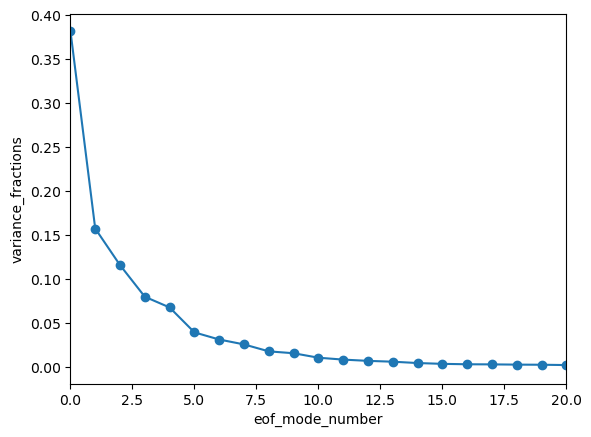

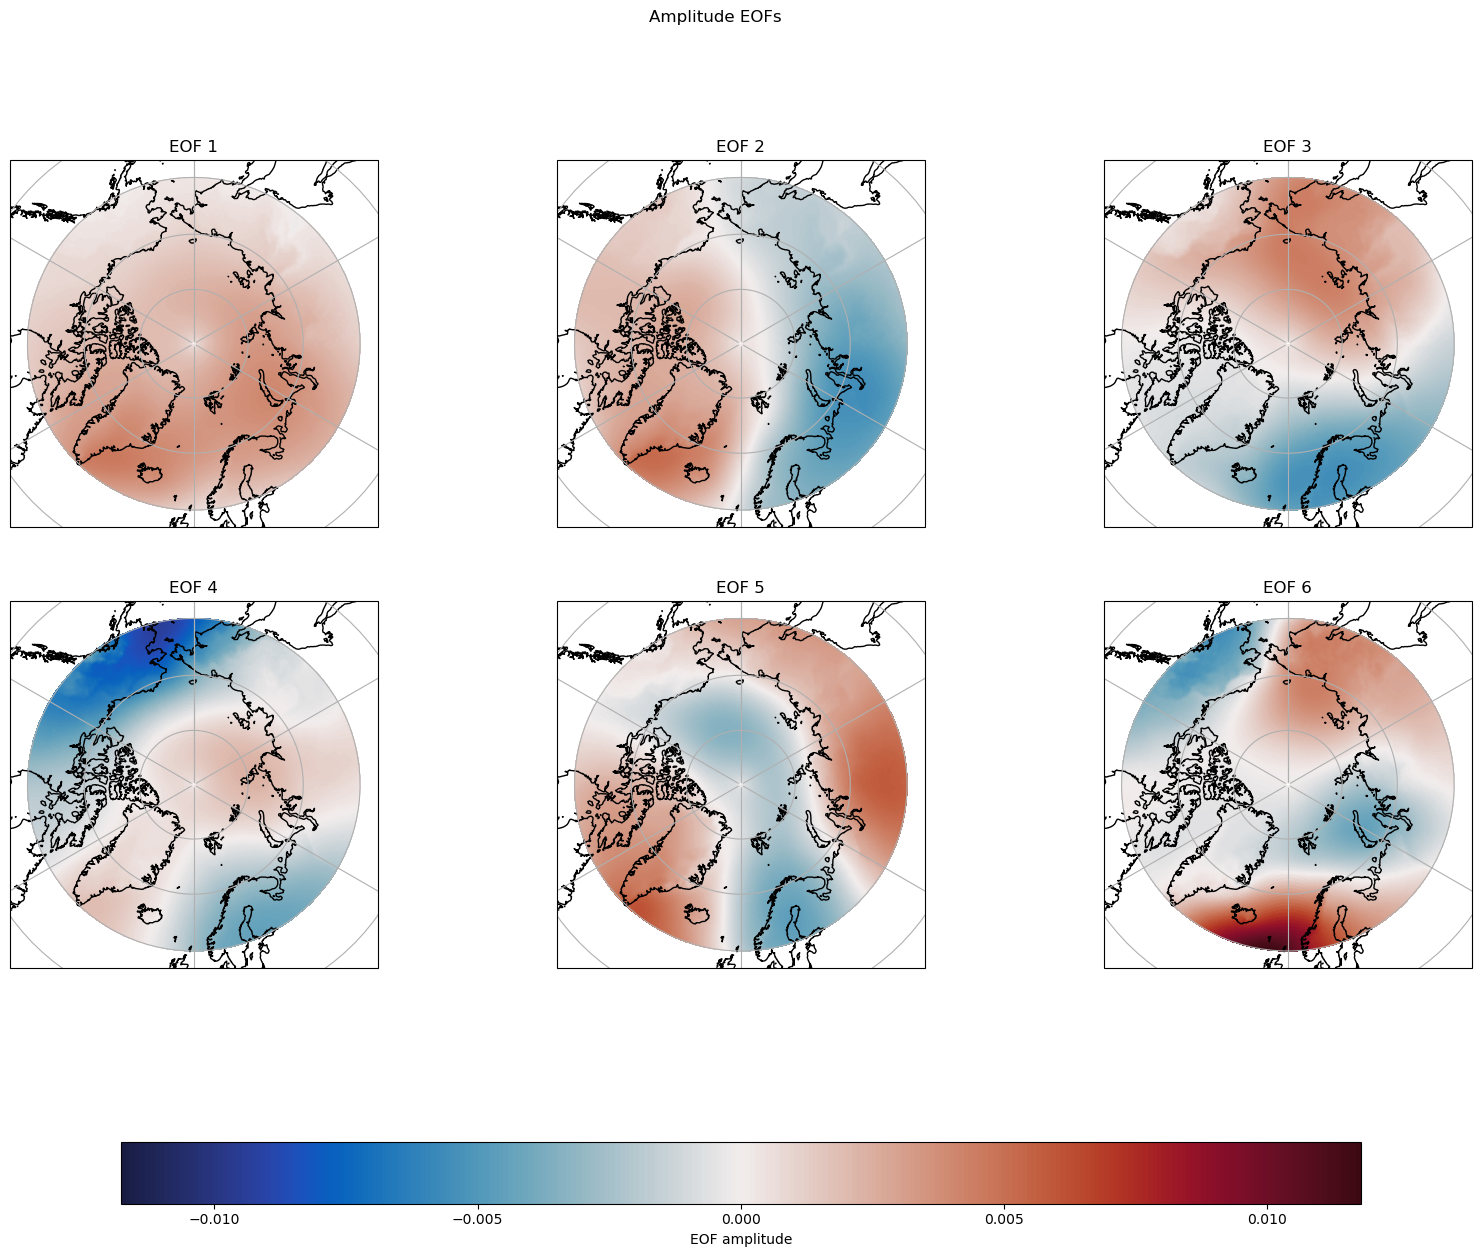

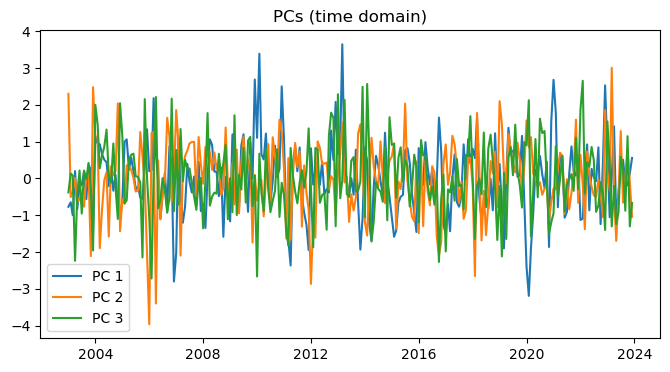

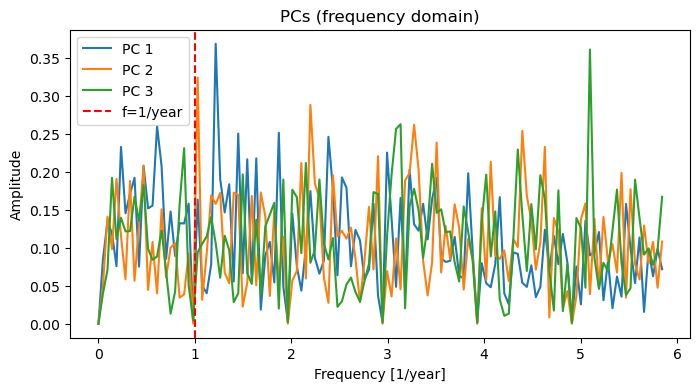

In [12]:
# Plotting EOFs
fast_eof_analysis(msl_eof_solver)

### AO ?

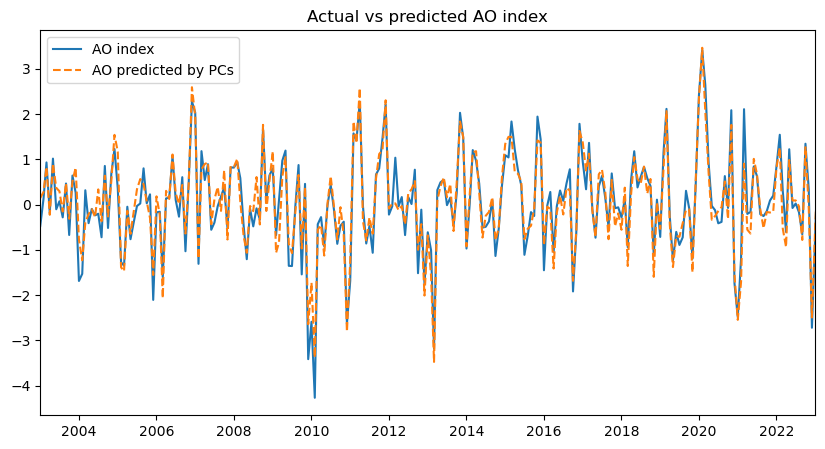

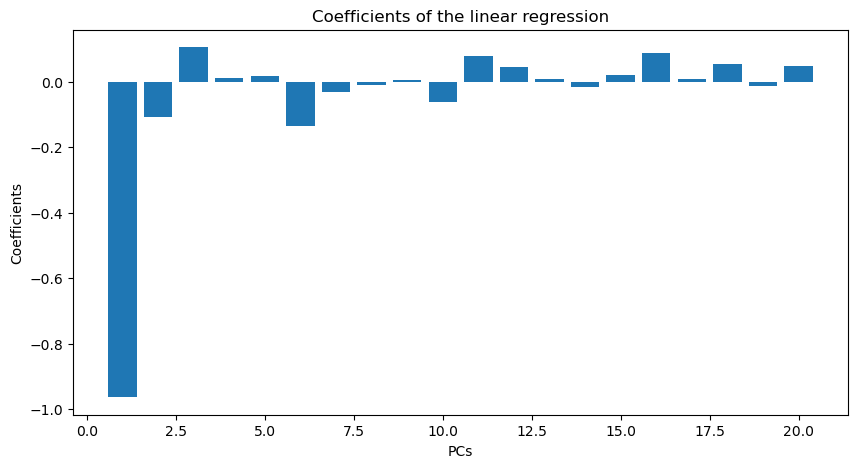

In [62]:
# Prepare the data
nb_pcs = 20
X = msl_eof_solver.pcs(1).values[:,:nb_pcs]
y = ds_climate_index['AO'].values

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Get the coefficients
coefficients = model.coef_
intercept = model.intercept_

# Predict the PC1 using the linear combination
pred = model.predict(X)

# Plot the actual vs predicted PC1
plt.figure(figsize=(10, 5))
plt.plot(msl_eof_solver.pcs(1).time, y, label='AO index')
plt.plot(msl_eof_solver.pcs(1).time, pred, label='AO predicted by PCs', linestyle='--')
plt.legend()
plt.title('Actual vs predicted AO index')
plt.xlim(pd.DatetimeIndex(['2003-01-01', '2023-01-01']))
plt.show()

# Plot the coefficients in the regression as histograms

plt.figure(figsize=(10, 5))
plt.bar(np.arange(1, nb_pcs+1), coefficients)
plt.xlabel('PCs')
plt.ylabel('Coefficients')
plt.title('Coefficients of the linear regression')
plt.show()



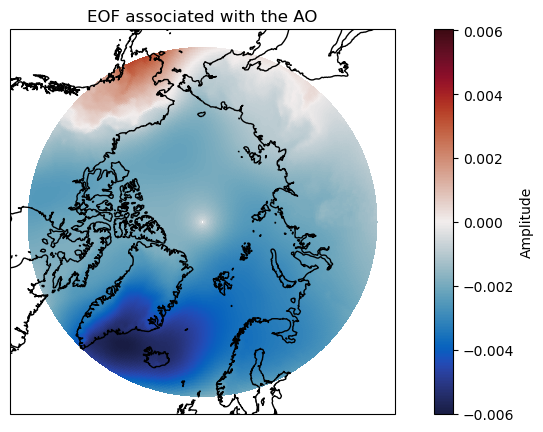

In [63]:
AO_PC = xr.DataArray(
    data = pred,
    dims = ['time'],
    coords = {'time': msl_eof_solver.pcs(1).time}
)
AO_EOF = 0
for i in range(nb_pcs):
    AO_EOF += coefficients[i] * msl_eof_solver.eofs()[i]


fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.NorthPolarStereo()})
pcm = ax.pcolormesh(AO_EOF.longitude, AO_EOF.latitude, AO_EOF, transform=ccrs.PlateCarree(), cmap=cmo.balance, vmin = -np.abs(AO_EOF).max(), vmax = np.abs(AO_EOF).max())
ax.coastlines()
plt.colorbar(pcm, ax=ax, label='Amplitude')
plt.title('EOF associated with the AO')
plt.show()



### NAO ?

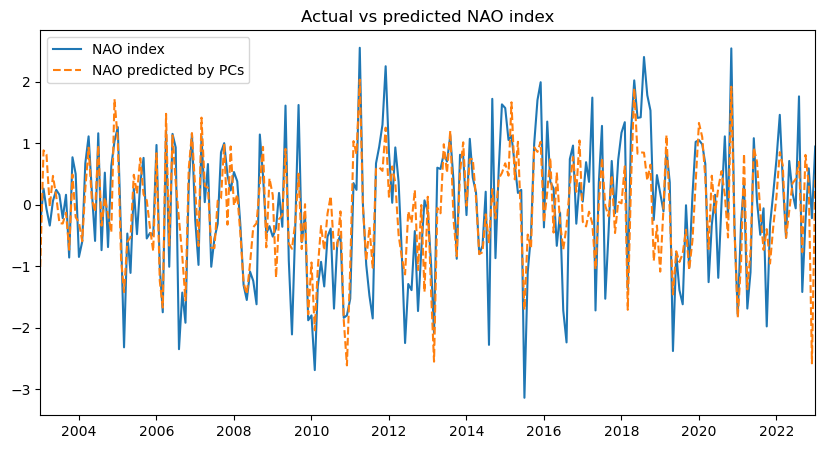

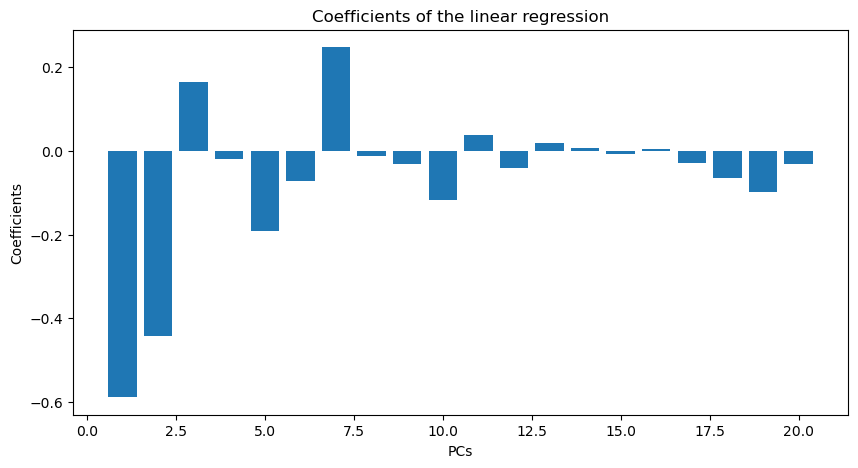

In [64]:
# Prepare the data
nb_pcs = 20
X = msl_eof_solver.pcs(1).values[:,:nb_pcs]
y = ds_climate_index['NAO'].values

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Get the coefficients
coefficients = model.coef_
intercept = model.intercept_


# Predict the PC1 using the linear combination
pred = model.predict(X)

# Plot the actual vs predicted PC1
plt.figure(figsize=(10, 5))
plt.plot(msl_eof_solver.pcs(1).time, y, label='NAO index')
plt.plot(msl_eof_solver.pcs(1).time, pred, label='NAO predicted by PCs', linestyle='--')
plt.legend()
plt.title('Actual vs predicted NAO index')
plt.xlim(pd.DatetimeIndex(['2003-01-01', '2023-01-01']))
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(np.arange(1, nb_pcs+1), coefficients)
plt.xlabel('PCs')
plt.ylabel('Coefficients')
plt.title('Coefficients of the linear regression')
plt.show()


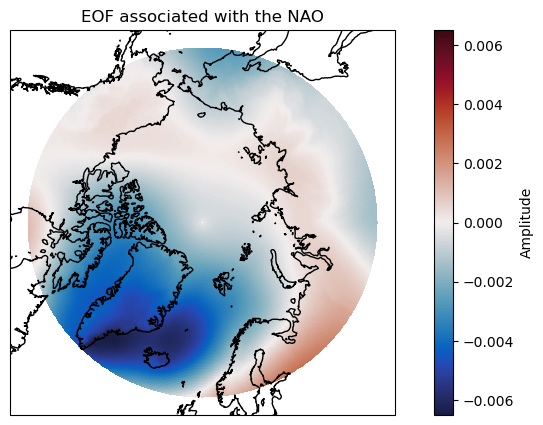

In [65]:
NAO_PC = xr.DataArray(
    data = pred,
    dims = ['time'],
    coords = {'time': msl_eof_solver.pcs(1).time}
)
NAO_EOF = 0
for i in range(nb_pcs):
    NAO_EOF += coefficients[i] * msl_eof_solver.eofs()[i]


fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.NorthPolarStereo()})
pcm = ax.pcolormesh(NAO_EOF.longitude, NAO_EOF.latitude, NAO_EOF, transform=ccrs.PlateCarree(), cmap=cmo.balance, vmin = -np.abs(NAO_EOF).max(), vmax = np.abs(NAO_EOF).max())
ax.coastlines()
plt.colorbar(pcm, ax=ax, label='Amplitude')
plt.title('EOF associated with the NAO')
plt.show()

### SOI ???

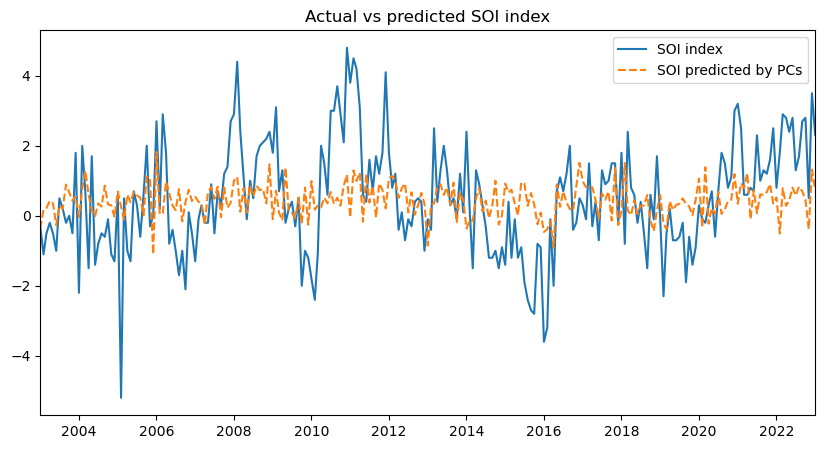

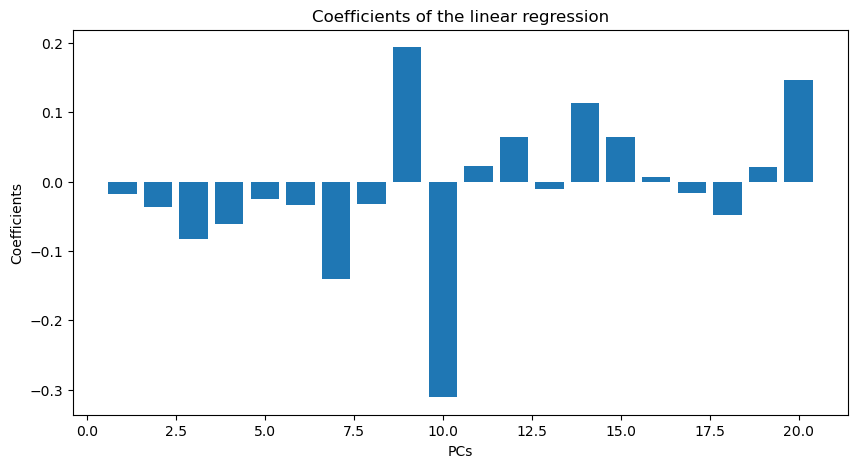

In [66]:
# Prepare the data
nb_pcs = 20
X = msl_eof_solver.pcs(1).values[:,:nb_pcs]
y = ds_climate_index['SOI'].values

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Get the coefficients
coefficients = model.coef_
intercept = model.intercept_


# Predict the PC1 using the linear combination
pred = model.predict(X)

# Plot the actual vs predicted PC1
plt.figure(figsize=(10, 5))
plt.plot(msl_eof_solver.pcs(1).time, y, label='SOI index')
plt.plot(msl_eof_solver.pcs(1).time, pred, label='SOI predicted by PCs', linestyle='--')
plt.legend()
plt.title('Actual vs predicted SOI index')
plt.xlim(pd.DatetimeIndex(['2003-01-01', '2023-01-01']))
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(np.arange(1, nb_pcs+1), coefficients)
plt.xlabel('PCs')
plt.ylabel('Coefficients')
plt.title('Coefficients of the linear regression')
plt.show()


Non quand même faut pas pousser

### Regressions on SLP EOFs

In [77]:
field_name = 'sst'

In [78]:
anomalies = ds_anomalies_detrended[field_name]
projection = (anomalies * msl_eof_solver.pcs(1, 10)).mean('time')

proj_AO = (anomalies * AO_PC).mean('time')
proj_NAO = (anomalies * NAO_PC).mean('time')

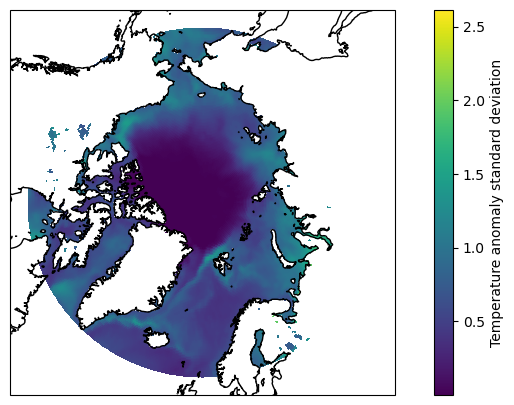

In [79]:
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.NorthPolarStereo()})
pcm = ax.pcolormesh(projection.longitude, projection.latitude, anomalies.std('time'), transform=ccrs.PlateCarree(), cmap='viridis')
ax.coastlines()
plt.colorbar(pcm, ax=ax, label='Temperature anomaly standard deviation')
plt.show()



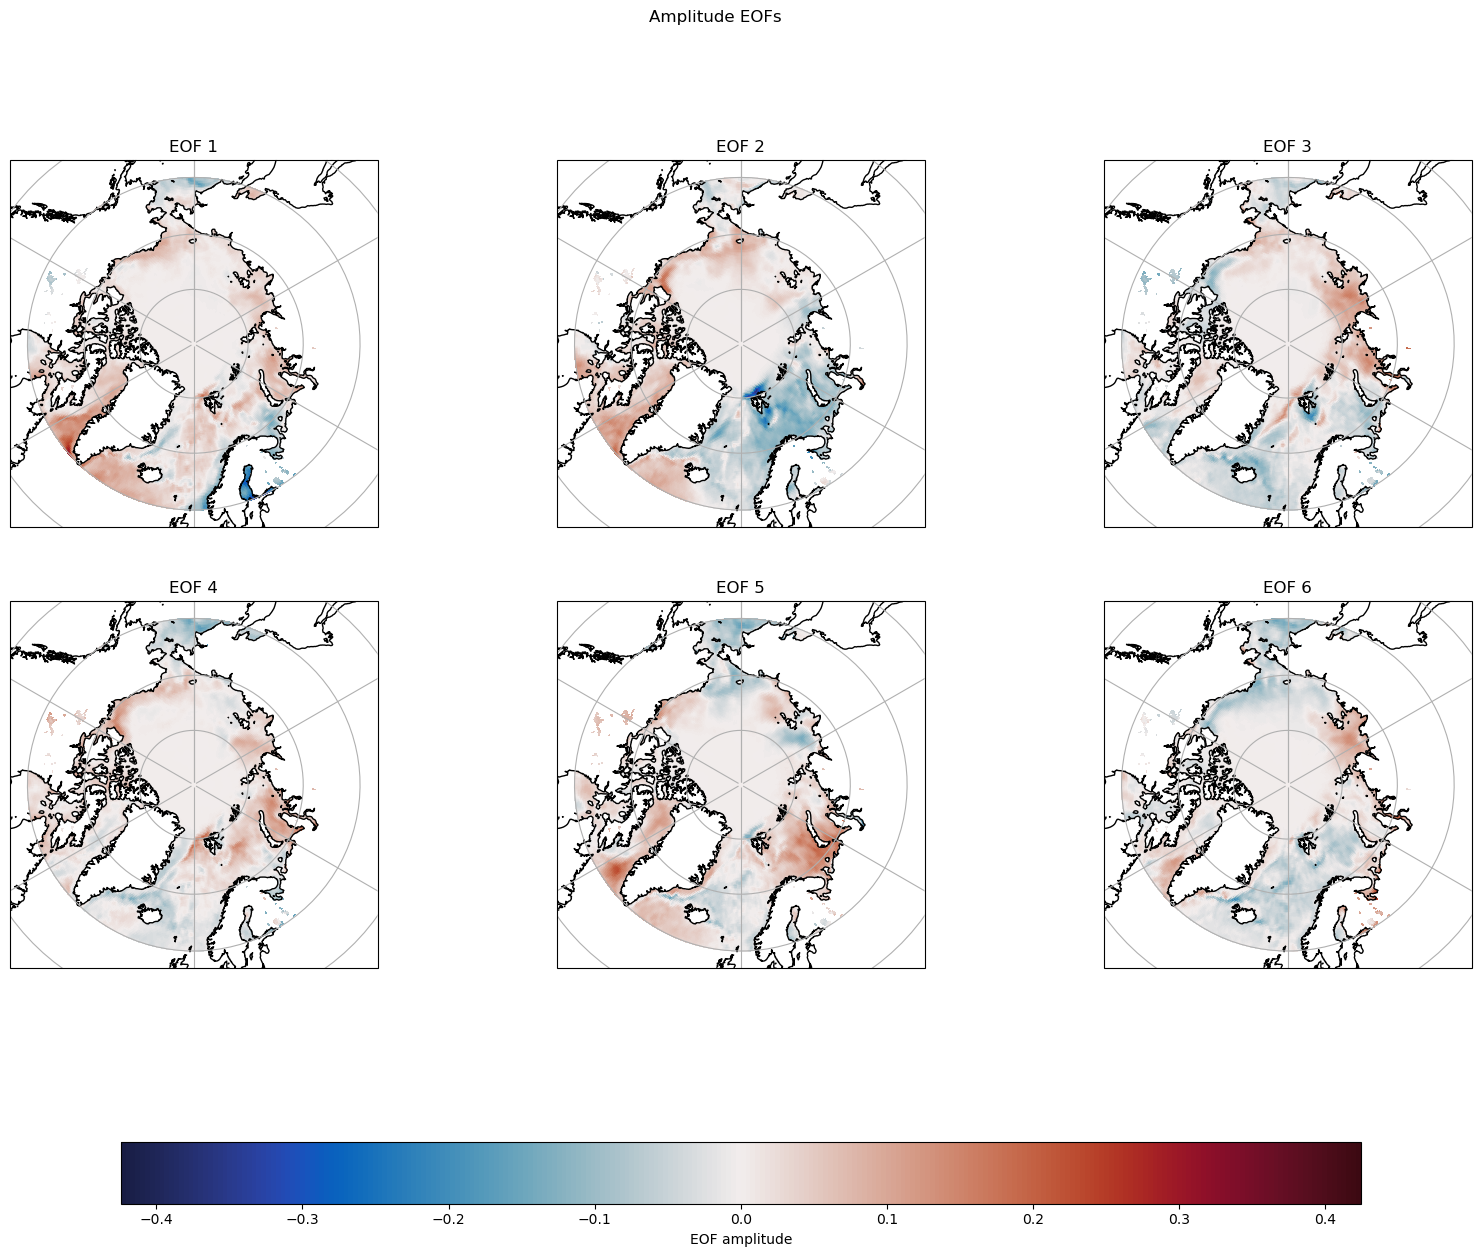

In [80]:
fig, axs = plt.subplots(2, 3, figsize=(20, 15), subplot_kw={'projection': ccrs.NorthPolarStereo()})

axs = axs.flatten()

max_val = np.abs(projection).max()

for i in range(6):
    ax = axs[i]
    ax.coastlines()
    ax.gridlines()
    pcm = ax.pcolormesh(
        projection.longitude, 
        projection.latitude, 
        projection.sel(mode=i), 
        transform=ccrs.PlateCarree(), 
        cmap=cmo.balance,
        norm=colors.Normalize(vmin=-max_val, vmax=max_val),
    )
    ax.set_title(f'EOF {i+1}')
plt.colorbar(pcm, ax=axs, label='EOF amplitude', orientation='horizontal', shrink=0.8)
plt.suptitle('Amplitude EOFs')
plt.show()

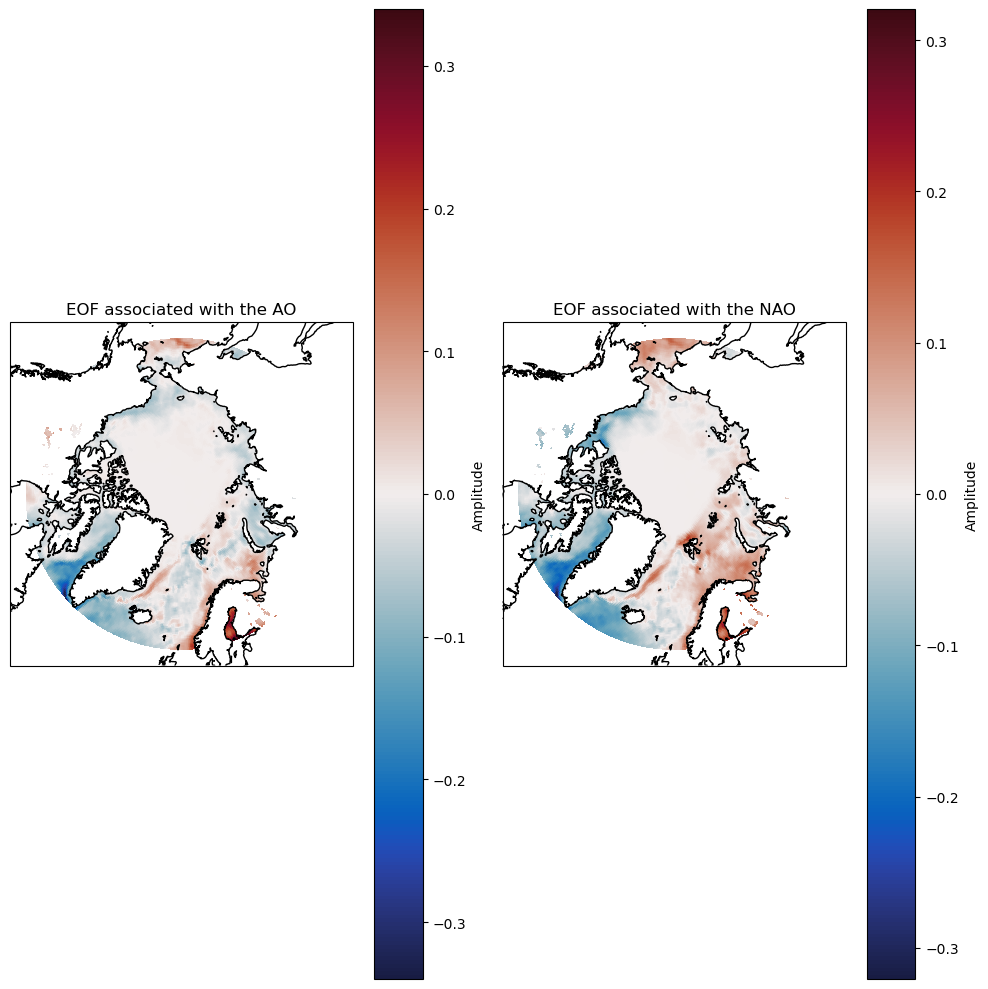

In [81]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10), subplot_kw={'projection': ccrs.NorthPolarStereo()})

# Plot EOF associated with the AO
ax = axs[0]
pcm = ax.pcolormesh(AO_EOF.longitude, AO_EOF.latitude, proj_AO, transform=ccrs.PlateCarree(), cmap=cmo.balance, vmin=-np.abs(proj_AO).max(), vmax=np.abs(proj_AO).max())
ax.coastlines()
plt.colorbar(pcm, ax=ax, label='Amplitude')
ax.set_title('EOF associated with the AO')

# Plot EOF associated with the NAO
ax = axs[1]
pcm = ax.pcolormesh(NAO_EOF.longitude, NAO_EOF.latitude, proj_NAO, transform=ccrs.PlateCarree(), cmap=cmo.balance, vmin=-np.abs(proj_NAO).max(), vmax=np.abs(proj_NAO).max())
ax.coastlines()
plt.colorbar(pcm, ax=ax, label='Amplitude')
ax.set_title('EOF associated with the NAO')

plt.tight_layout()
plt.show()